## Data Ingestion

In [1]:
import os
import sys
import copy
import time
import random
import pyspark

from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, size, max, abs, split, col
from pyspark.sql.functions import datediff,unix_timestamp, round
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mizani.formatters import date_format
from plotnine import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

import warnings
warnings.filterwarnings('ignore')

In [2]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Predictive Maintenance") \
        .config("spark.some.config.option", "some-value") \
        .config("spark.executor.memory", "70g")\
        .config("spark.driver.memory", "50g")\
        .config("spark.memory.offHeap.enabled", "true")\
        .config("spark.memory.offHeap.size","30g")\
        .getOrCreate()
    return spark

spark = init_spark()
spark.conf.set("spark.sql.session.timeZone", "UTC")

In [3]:
filename = "..\data\machines.csv"
machines = spark.read.csv(filename, sep=',', header=True)

print(machines.count())
machines.show()

1000
+---------+------+---+
|machineID| model|age|
+---------+------+---+
|        1|model2| 18|
|        2|model4|  7|
|        3|model3|  8|
|        4|model3|  7|
|        5|model2|  2|
|        6|model3|  7|
|        7|model4| 20|
|        8|model3| 16|
|        9|model1|  7|
|       10|model1| 10|
|       11|model4|  6|
|       12|model2|  9|
|       13|model3| 15|
|       14|model4|  1|
|       15|model4| 14|
|       16|model3|  3|
|       17|model4| 14|
|       18|model4| 15|
|       19|model4| 17|
|       20|model2| 16|
+---------+------+---+
only showing top 20 rows



In [4]:
filename = "..\data\errors.csv"
errors = spark.read.csv(filename, sep=',', header=True)

print(errors.count())
errors.show()

11967
+-------------------+---------+-------+
|           datetime|machineID|errorID|
+-------------------+---------+-------+
|2015-01-06 03:00:00|        1| error3|
|2015-02-03 06:00:00|        1| error4|
|2015-02-21 11:00:00|        1| error1|
|2015-02-21 16:00:00|        1| error2|
|2015-03-20 06:00:00|        1| error1|
|2015-04-04 06:00:00|        1| error5|
|2015-05-04 06:00:00|        1| error4|
|2015-05-19 06:00:00|        1| error2|
|2015-05-19 06:00:00|        1| error3|
|2015-06-03 06:00:00|        1| error5|
|2015-06-18 06:00:00|        1| error2|
|2015-06-18 06:00:00|        1| error3|
|2015-08-02 06:00:00|        1| error4|
|2015-08-02 06:00:00|        1| error5|
|2015-10-31 06:00:00|        1| error5|
|2015-11-15 06:00:00|        1| error1|
|2015-12-15 06:00:00|        1| error5|
|2015-01-31 06:00:00|        2| error2|
|2015-01-31 06:00:00|        2| error3|
|2015-04-01 06:00:00|        2| error2|
+-------------------+---------+-------+
only showing top 20 rows



In [5]:
filename = "..\data\\failures.csv"
failures  = spark.read.csv(filename, sep=',', header=True)

print(failures.count())
failures.show()

6726
+-------------------+---------+-------+
|           datetime|machineID|failure|
+-------------------+---------+-------+
|2015-02-04 06:00:00|        1|  comp3|
|2015-03-21 06:00:00|        1|  comp1|
|2015-04-05 06:00:00|        1|  comp4|
|2015-05-05 06:00:00|        1|  comp3|
|2015-05-20 06:00:00|        1|  comp2|
|2015-06-04 06:00:00|        1|  comp4|
|2015-06-19 06:00:00|        1|  comp2|
|2015-08-03 06:00:00|        1|  comp3|
|2015-08-03 06:00:00|        1|  comp4|
|2015-11-01 06:00:00|        1|  comp4|
|2015-11-16 06:00:00|        1|  comp1|
|2015-12-16 06:00:00|        1|  comp4|
|2015-01-02 03:00:00|        2|  comp2|
|2015-02-01 06:00:00|        2|  comp2|
|2015-04-02 06:00:00|        2|  comp2|
|2015-04-17 06:00:00|        2|  comp1|
|2015-06-01 06:00:00|        2|  comp2|
|2015-08-15 06:00:00|        2|  comp1|
|2015-09-29 06:00:00|        2|  comp1|
|2015-01-07 06:00:00|        3|  comp1|
+-------------------+---------+-------+
only showing top 20 rows



In [6]:
filename = "..\data\\maint.csv"
maintenance  = spark.read.csv(filename, sep=',', header=True)

print(maintenance.count())
maintenance.show()

32592
+-------------------+---------+-----+
|           datetime|machineID| comp|
+-------------------+---------+-----+
|2014-07-01 06:00:00|        1|comp4|
|2014-09-14 06:00:00|        1|comp1|
|2014-09-14 06:00:00|        1|comp2|
|2014-11-13 06:00:00|        1|comp3|
|2015-01-05 06:00:00|        1|comp1|
|2015-01-20 06:00:00|        1|comp1|
|2015-02-04 06:00:00|        1|comp3|
|2015-02-19 06:00:00|        1|comp3|
|2015-03-06 06:00:00|        1|comp3|
|2015-03-21 06:00:00|        1|comp1|
|2015-04-05 06:00:00|        1|comp1|
|2015-04-05 06:00:00|        1|comp4|
|2015-04-20 06:00:00|        1|comp1|
|2015-05-05 06:00:00|        1|comp3|
|2015-05-20 06:00:00|        1|comp2|
|2015-06-04 06:00:00|        1|comp4|
|2015-06-04 06:00:00|        1|comp3|
|2015-06-19 06:00:00|        1|comp2|
|2015-06-19 06:00:00|        1|comp4|
|2015-07-04 06:00:00|        1|comp2|
+-------------------+---------+-----+
only showing top 20 rows



In [7]:
filename = "..\data\\telemetry.csv"
telemetry = spark.read.csv(filename, sep=',', header=True)
telemetry_pd = pd.read_csv("..\data\\telemetry.csv")

print(telemetry.count())
telemetry.limit(10).toPandas().head(10)

8761000


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,151.919998705647,530.813577555042,101.788175260076,49.6040134898504
1,2015-01-01 07:00:00,1,174.522001096471,535.523532319384,113.256009499254,41.5159054753218
2,2015-01-01 08:00:00,1,146.912821646066,456.080746005808,107.786964633461,42.0996936545816
3,2015-01-01 09:00:00,1,179.530560852404,503.469990485512,108.283817221771,37.8477274946112
4,2015-01-01 10:00:00,1,180.544276621327,371.600611295334,107.55330679883,41.4678800376109
5,2015-01-01 11:00:00,1,141.41175703074,530.857266087542,87.6140012779218,44.9858461978707
6,2015-01-01 12:00:00,1,184.083821743344,450.2275288129,87.6973797069792,30.8312627133489
7,2015-01-01 13:00:00,1,166.632618417563,486.466837788584,108.067733800301,50.3800539242367
8,2015-01-01 14:00:00,1,159.892748369181,488.968697483274,102.131884360457,43.661296546187
9,2015-01-01 15:00:00,1,176.686811672085,508.202759433056,90.9511892146129,43.039695633682


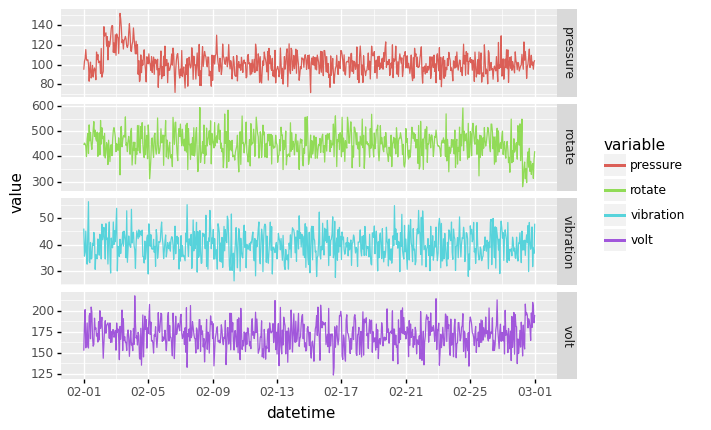

<ggplot: (-9223371897926238222)>

In [8]:
plt_data = telemetry_pd.loc[telemetry_pd['machineID'] == 1]

# format datetime field which comes in as string
plt_data['datetime'] = pd.to_datetime(plt_data['datetime'], format="%Y-%m-%d %H:%M:%S")


# Quick plot to show structure
plot_df = plt_data.loc[(plt_data['datetime'] >= pd.to_datetime('2015-02-01')) &
                       (plt_data['datetime'] <= pd.to_datetime('2015-03-01'))]

plt_data = pd.melt(plot_df, id_vars=['datetime', 'machineID'])

ggplot(aes(x="datetime", y="value", color = "variable", group="variable"), plt_data) +\
    geom_line() +\
    scale_x_date(labels=date_format('%m-%d')) +\
    facet_grid('variable ~ .', scales='free_y')

In [9]:
def plot_ts(series, figsize=(40, 20), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def plot_ts2(ax, values, times, label=None, color='blue', xmin=None, xmax=None, ymin=None, ymax=None, anomalies=None):
    step = 700
    if xmin is not None:
        assert(xmax is not None)
        ax.set(xlim=(xmin, xmax))
    if ymin is not None:
        assert(ymax is not None)
        ax.set(ylim=(ymin, ymax))
    if xmin is None:
        ax.set_xticks([i for i in range(len(values)) if i % step == 0])
        ax.set_xticklabels([times[i] for i in range(len(values)) if i % step == 0])
    ax.plot(values, label=label, color=color)
    if anomalies is not None:
        x, y = anomalies
        ax.scatter(x, y, label='Anomalies', color='red')
    if label is not None:
        ax.legend()

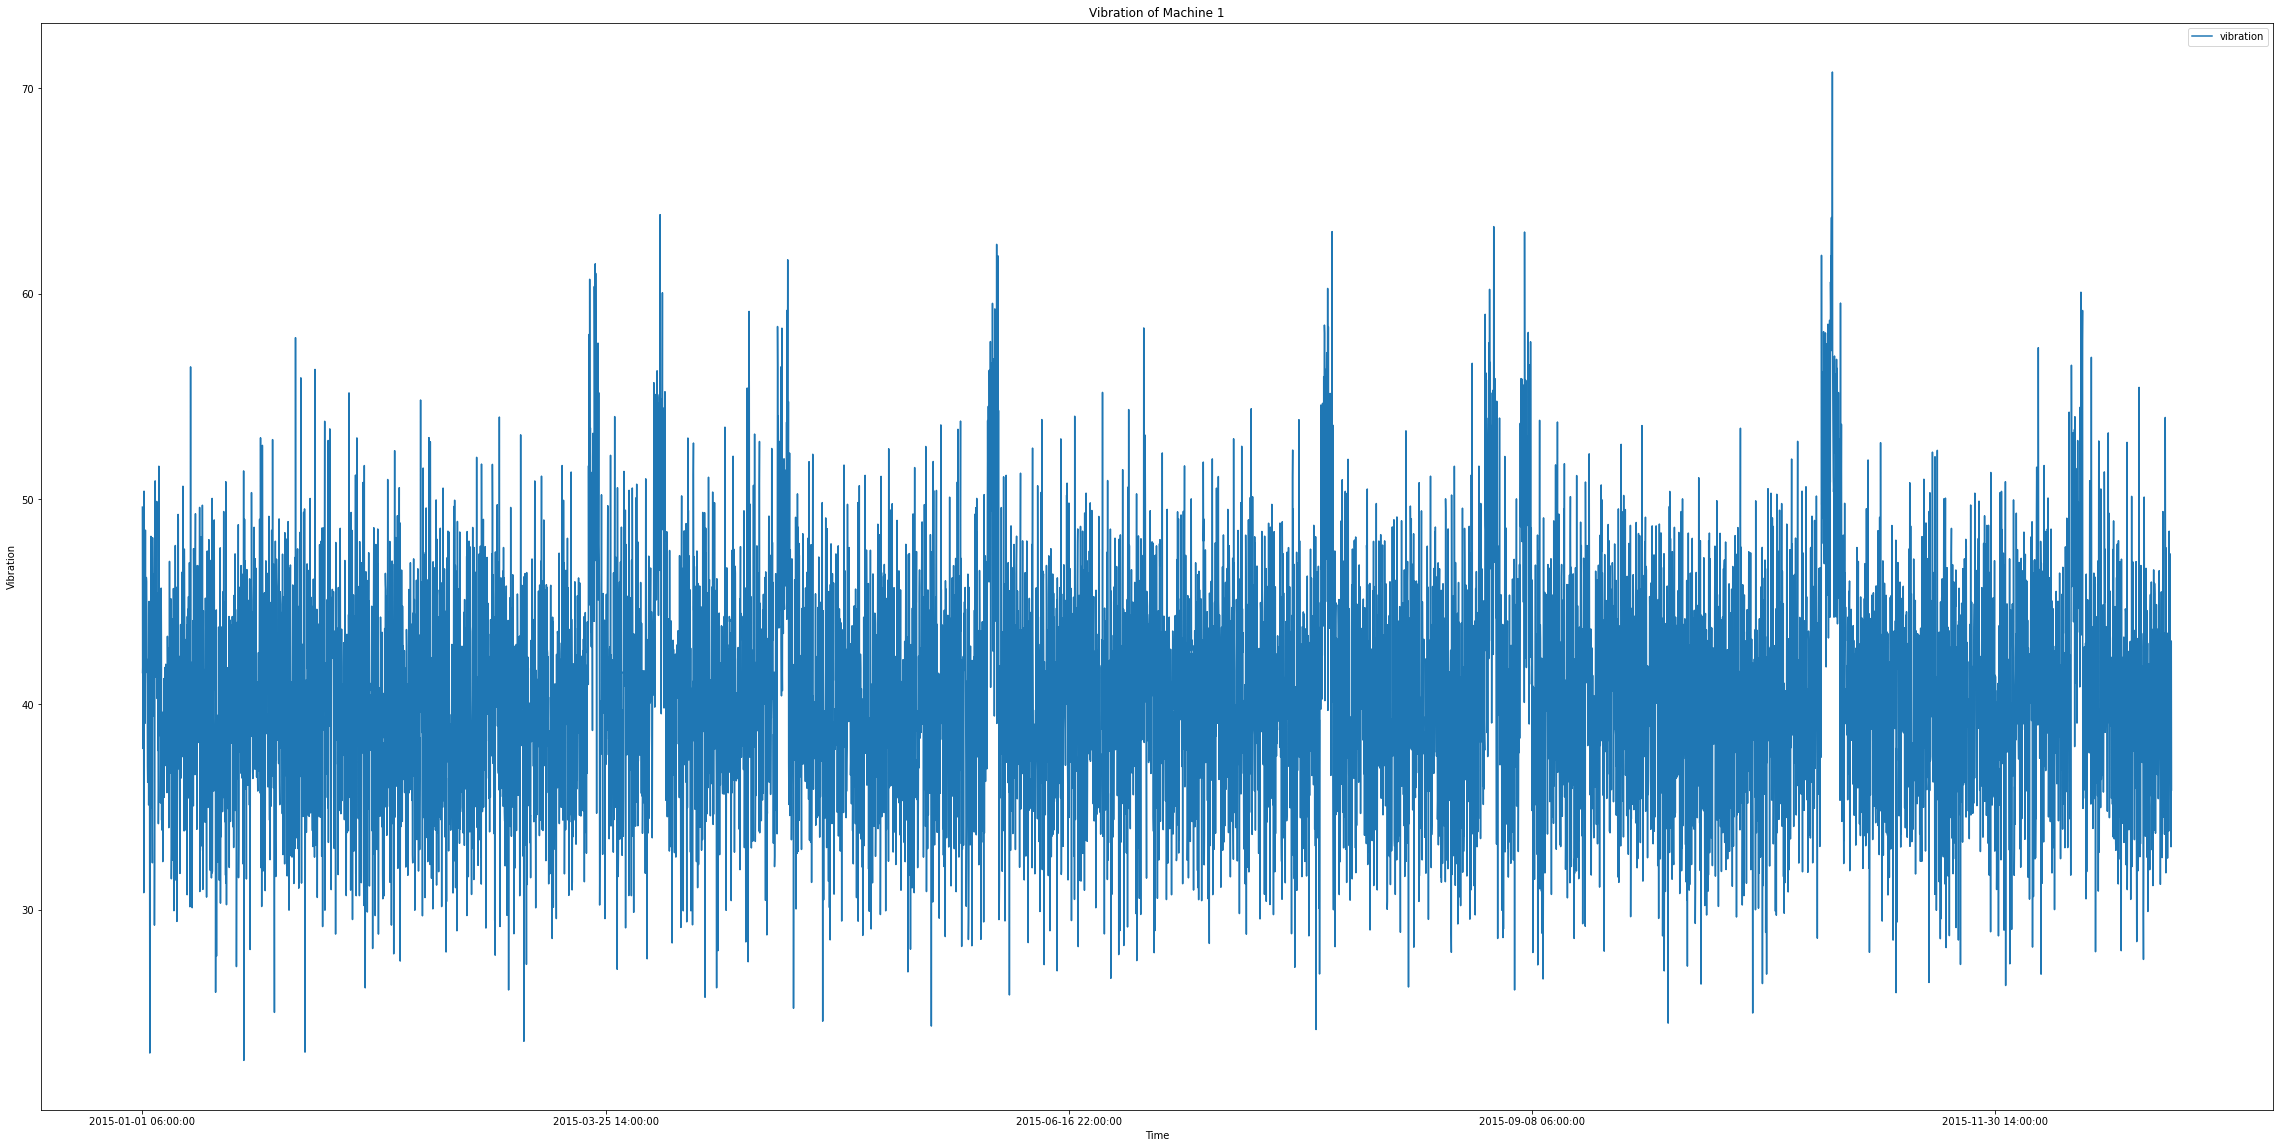

In [10]:
#telemetry_values = telemetry['volt']
#telemetry_dates = telemetry['datetime']
#plot_ts(ax, telemetry_values, telemetry_dates, label="volt", color='green')

df_vib_machine_1 = telemetry_pd[
    telemetry_pd.machineID == 1][["datetime", "vibration"]].set_index("datetime")

plot_ts(df_vib_machine_1, title="Vibration of Machine 1", xlabel="Time", ylabel="Vibration")

# Time Window

In [11]:
# rolling mean and standard deviation
# Temporary storage for rolling means
tel_mean = telemetry

# Engineer features
rolling_features = ['volt','rotate', 'pressure', 'vibration']
      
# n hours = n * 3600 seconds  
time_val = 12 * 3600

# Choose the time_val hour timestamps to align the data
# dt_truncated looks at the column named "datetime" in the current data set.
# remember that Spark is lazy... this doesn't execute until it is in a withColumn statement.
# test = tel_mean.withColumn("dt_truncated", dt_truncated).drop('volt', 'rotate', 'pressure', 'vibration').show()
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

In [12]:
lags = [12, 24, 36] #in hours

# align the data
for lag_n in lags:
    wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-lag_n, 0)
    for col_name in rolling_features:
        tel_mean = tel_mean.withColumn(col_name+'_rollingmean_'+str(lag_n), 
                                       F.avg(col(col_name)).over(wSpec))
        tel_mean = tel_mean.withColumn(col_name+'_rollingstd_'+str(lag_n), 
                                       F.stddev(col(col_name)).over(wSpec))

# Calculate lag values...
telemetry_feat = (tel_mean.withColumn("dt_truncated", dt_truncated)
                  .drop('volt', 'rotate', 'pressure', 'vibration')
                  .fillna(0)
                  .groupBy("machineID","dt_truncated")
                  .agg(F.mean('volt_rollingmean_12').alias('volt_rollingmean_12'),
                       F.mean('rotate_rollingmean_12').alias('rotate_rollingmean_12'), 
                       F.mean('pressure_rollingmean_12').alias('pressure_rollingmean_12'), 
                       F.mean('vibration_rollingmean_12').alias('vibration_rollingmean_12'), 
                       F.mean('volt_rollingmean_24').alias('volt_rollingmean_24'),
                       F.mean('rotate_rollingmean_24').alias('rotate_rollingmean_24'), 
                       F.mean('pressure_rollingmean_24').alias('pressure_rollingmean_24'), 
                       F.mean('vibration_rollingmean_24').alias('vibration_rollingmean_24'),
                       F.mean('volt_rollingmean_36').alias('volt_rollingmean_36'),
                       F.mean('vibration_rollingmean_36').alias('vibration_rollingmean_36'),
                       F.mean('rotate_rollingmean_36').alias('rotate_rollingmean_36'), 
                       F.mean('pressure_rollingmean_36').alias('pressure_rollingmean_36'), 
                       F.stddev('volt_rollingstd_12').alias('volt_rollingstd_12'),
                       F.stddev('rotate_rollingstd_12').alias('rotate_rollingstd_12'), 
                       F.stddev('pressure_rollingstd_12').alias('pressure_rollingstd_12'), 
                       F.stddev('vibration_rollingstd_12').alias('vibration_rollingstd_12'), 
                       F.stddev('volt_rollingstd_24').alias('volt_rollingstd_24'),
                       F.stddev('rotate_rollingstd_24').alias('rotate_rollingstd_24'), 
                       F.stddev('pressure_rollingstd_24').alias('pressure_rollingstd_24'), 
                       F.stddev('vibration_rollingstd_24').alias('vibration_rollingstd_24'),
                       F.stddev('volt_rollingstd_36').alias('volt_rollingstd_36'),
                       F.stddev('rotate_rollingstd_36').alias('rotate_rollingstd_36'), 
                       F.stddev('pressure_rollingstd_36').alias('pressure_rollingstd_36'), 
                       F.stddev('vibration_rollingstd_36').alias('vibration_rollingstd_36'), ))

print(tel_mean.count())
print(telemetry_feat.count())
telemetry_feat.where((col("machineID") == 2)).limit(20).toPandas().head(20)

8761000
731000


,machineID,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,pressure_rollingstd_12,vibration_rollingstd_12,volt_rollingstd_24,rotate_rollingstd_24,pressure_rollingstd_24,vibration_rollingstd_24,volt_rollingstd_36,rotate_rollingstd_36,pressure_rollingstd_36,vibration_rollingstd_36
0,2,2015-01-01 12:00:00,174.021269,364.628758,104.305572,37.734298,174.021269,364.628758,104.305572,37.734298,...,5.734924,2.040865,2.255246,12.601551,5.734924,2.040865,2.255246,12.601551,5.734924,2.040865
1,2,2015-01-02 00:00:00,172.410654,378.828905,106.422811,38.955821,172.651831,377.019502,105.871557,38.691360,...,1.432061,0.491780,1.318545,2.208356,0.430819,0.188705,1.318545,2.208356,0.430819,0.188705
2,2,2015-01-02 12:00:00,175.351382,434.746193,96.717037,40.214446,173.881018,406.787549,101.569924,39.585134,...,0.956883,0.415326,1.736694,11.151292,0.869426,0.183365,1.166317,8.706121,0.256471,0.067010
3,2,2015-01-03 00:00:00,166.902611,465.822485,96.642844,40.142349,171.126996,450.284339,96.679940,40.178397,...,0.510710,0.251343,0.665744,9.824338,0.281947,0.196957,0.918050,0.769643,0.840766,0.158261
4,2,2015-01-03 12:00:00,160.464732,439.829838,98.187198,39.365047,163.683672,452.826162,97.415021,39.753698,...,0.614385,0.971705,2.149661,4.511795,0.364070,0.573136,0.321523,6.957997,0.333760,0.361615
5,2,2015-01-04 00:00:00,177.885080,442.478378,99.178132,38.158251,169.174906,441.154108,98.682665,38.761649,...,1.235634,0.609093,0.756529,2.261044,0.295931,0.150570,0.746225,3.366718,0.312873,0.100657
6,2,2015-01-04 12:00:00,188.942554,445.501575,99.990250,40.434978,183.413817,443.989977,99.584191,39.296615,...,1.648919,0.698885,1.744901,1.767896,0.822064,0.402329,0.526149,1.526332,0.484243,0.252154
7,2,2015-01-05 00:00:00,189.172233,437.288367,102.442699,40.213729,189.057394,441.394971,101.216475,40.324354,...,1.540622,0.939221,1.303463,2.323860,0.415773,0.124461,0.964744,0.839692,0.173806,0.227214
8,2,2015-01-05 12:00:00,188.186780,435.436494,102.540723,40.230162,188.679507,436.362431,102.491711,40.221945,...,0.934311,0.924633,1.316141,2.798627,0.745656,0.619067,1.021187,1.897061,0.189636,0.197370
9,2,2015-01-06 00:00:00,179.804861,460.151032,98.635580,41.486785,183.995821,447.793763,100.588152,40.858473,...,0.502338,0.337345,1.297683,2.315692,0.434618,0.189186,1.403022,1.887292,0.395973,0.338036


In [13]:
# create a column for each errorID 
error_ind = (errors.groupBy("machineID","datetime","errorID").pivot('errorID')
             .agg(F.count('machineID').alias('dummy')).drop('errorID').fillna(0)
             .groupBy("machineID","datetime")
             .agg(F.sum('error1').alias('error1sum'), 
                  F.sum('error2').alias('error2sum'), 
                  F.sum('error3').alias('error3sum'), 
                  F.sum('error4').alias('error4sum'), 
                  F.sum('error5').alias('error5sum')))

# join the telemetry data with errors
error_count = (telemetry.join(error_ind, 
                              ((telemetry['machineID'] == error_ind['machineID']) 
                               & (telemetry['datetime'] == error_ind['datetime'])), "left")
               .drop('volt', 'rotate', 'pressure', 'vibration')
               .drop(error_ind.machineID).drop(error_ind.datetime)
               .fillna(0))

error_features = ['error1sum','error2sum', 'error3sum', 'error4sum', 'error5sum']

wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-24, 0)
for col_name in error_features:
    # We're only interested in the erros in the previous 24 hours.
    error_count = error_count.withColumn(col_name+'_rollingmean_24', 
                                         F.avg(col(col_name)).over(wSpec))

error_feat = (error_count.withColumn("dt_truncated", dt_truncated)
              .drop('error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum').fillna(0)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('error1sum_rollingmean_24').alias('error1sum_rollingmean_24'), 
                   F.mean('error2sum_rollingmean_24').alias('error2sum_rollingmean_24'), 
                   F.mean('error3sum_rollingmean_24').alias('error3sum_rollingmean_24'), 
                   F.mean('error4sum_rollingmean_24').alias('error4sum_rollingmean_24'), 
                   F.mean('error5sum_rollingmean_24').alias('error5sum_rollingmean_24')))

print(error_feat.count())
error_feat.limit(10).toPandas().head(10)

731000


,machineID,dt_truncated,error1sum_rollingmean_24,error2sum_rollingmean_24,error3sum_rollingmean_24,error4sum_rollingmean_24,error5sum_rollingmean_24
0,296,2015-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0
1,296,2015-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0
2,296,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
3,296,2015-01-03 00:00:00,0.0,0.0,0.0,0.0,0.0
4,296,2015-01-03 12:00:00,0.0,0.0,0.0,0.0,0.0
5,296,2015-01-04 00:00:00,0.0,0.0,0.0,0.0,0.0
6,296,2015-01-04 12:00:00,0.0,0.0,0.0,0.0,0.0
7,296,2015-01-05 00:00:00,0.0,0.0,0.0,0.0,0.0
8,296,2015-01-05 12:00:00,0.0,0.0,0.0,0.0,0.0
9,296,2015-01-06 00:00:00,0.0,0.0,0.0,0.0,0.0


In [14]:
# create a column for each component replacement
maint_replace = (maintenance.groupBy("machineID","datetime","comp").pivot('comp')
                 .agg(F.count('machineID').alias('dummy')).fillna(0)
                 .groupBy("machineID","datetime")
                 .agg(F.sum('comp1').alias('comp1sum'), 
                      F.sum('comp2').alias('comp2sum'), 
                      F.sum('comp3').alias('comp3sum'),
                      F.sum('comp4').alias('comp4sum')))

maint_replace = maint_replace.withColumnRenamed('datetime','datetime_maint')

print(maint_replace.count())
maint_replace.limit(10).toPandas().head(10)

25121


,machineID,datetime_maint,comp1sum,comp2sum,comp3sum,comp4sum
0,998,2015-05-18 06:00:00,0,0,0,1
1,345,2015-01-21 06:00:00,1,0,1,0
2,777,2015-09-09 06:00:00,0,0,1,1
3,935,2015-07-01 06:00:00,1,1,0,0
4,811,2015-06-12 06:00:00,0,0,0,1
5,879,2015-11-04 06:00:00,0,1,1,0
6,908,2015-06-26 06:00:00,1,0,0,1
7,214,2015-10-24 06:00:00,0,0,1,0
8,241,2015-10-02 06:00:00,1,0,1,0
9,659,2015-01-25 06:00:00,0,1,0,0


In [15]:
# We want to align the component information on telemetry features timestamps.
telemetry_times = telemetry_feat.select(telemetry_feat.machineID, telemetry_feat.dt_truncated)\
                    .withColumnRenamed('dt_truncated','datetime_tel')

# Grab 4 component
for i in range(4):
    maint_comp = maint_replace.where(col(f'comp{i+1}sum') == '1')\
                    .withColumnRenamed('datetime','datetime_maint')\
                    .drop(f'comp{(i+1)%4+1}sum', f'comp{(i+2)%4+1}sum', f'comp{(i+3)%4+1}sum')

    # Within each machine, get the last replacement date for each timepoint
    maint_tel_comp = telemetry_times.join(maint_comp, 
                    ((telemetry_times['machineID']== maint_comp['machineID']) 
                    & (telemetry_times['datetime_tel'] > maint_comp['datetime_maint'])
                    & ( maint_comp[f'comp{i+1}sum'] == '1')))\
                       .drop(maint_comp.machineID)

    # Calculate the number of days between replacements
    comp = maint_tel_comp.withColumn(f'sincelastcomp{i+1}', 
            datediff(maint_tel_comp.datetime_tel, maint_tel_comp.datetime_maint))\
            .drop(maint_tel_comp.datetime_maint).drop(maint_tel_comp[f'comp{i+1}sum'])
    #print(comp.count())
    #comp.filter(comp.machineID == '1').orderBy(comp.datetime_tel).limit(20).toPandas().head(20)
    
    # Join component
    if i+1 == 1:
        comps_feat = comp
    else:
        comps_feat = (comps_feat.join(comp, 
            ((comps_feat['machineID'] == comp['machineID']) & 
             (comps_feat['datetime_tel'] == comp['datetime_tel'])), "left")\
           .drop(comp.machineID).drop(comp.datetime_tel))
    
comps_feat = comps_feat.groupBy("machineID", "datetime_tel")\
                   .agg(F.max('sincelastcomp1').alias('sincelastcomp1'), 
                        F.max('sincelastcomp2').alias('sincelastcomp2'), 
                        F.max('sincelastcomp3').alias('sincelastcomp3'), 
                        F.max('sincelastcomp4').alias('sincelastcomp4'))\
                   .fillna(0)
comps_feat.filter(comps_feat.machineID == '1').orderBy(comps_feat.datetime_tel).limit(20).toPandas().head(20)

,machineID,datetime_tel,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4
0,1,2015-01-01 12:00:00,109,109,49,184
1,1,2015-01-02 00:00:00,110,110,50,185
2,1,2015-01-02 12:00:00,110,110,50,185
3,1,2015-01-03 00:00:00,111,111,51,186
4,1,2015-01-03 12:00:00,111,111,51,186
5,1,2015-01-04 00:00:00,112,112,52,187
6,1,2015-01-04 12:00:00,112,112,52,187
7,1,2015-01-05 00:00:00,113,113,53,188
8,1,2015-01-05 12:00:00,113,113,53,188
9,1,2015-01-06 00:00:00,114,114,54,189


In [16]:
# Choose the time_val hour timestamps to align the data
dt_truncated = ((round(unix_timestamp(col("datetime_tel")) / time_val) * time_val).cast("timestamp"))

# Collect data
maint_feat = (comps_feat.withColumn("dt_truncated", dt_truncated)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('sincelastcomp1').alias('comp1sum'), 
                   F.mean('sincelastcomp2').alias('comp2sum'), 
                   F.mean('sincelastcomp3').alias('comp3sum'), 
                   F.mean('sincelastcomp4').alias('comp4sum')))

print(maint_feat.count())
maint_feat.limit(10).toPandas().head(10)

731000


,machineID,dt_truncated,comp1sum,comp2sum,comp3sum,comp4sum
0,1,2015-01-12 12:00:00,120.0,120.0,60.0,195.0
1,1,2015-06-03 12:00:00,262.0,262.0,202.0,337.0
2,1,2015-09-19 12:00:00,370.0,370.0,310.0,445.0
3,10,2015-02-22 00:00:00,116.0,86.0,56.0,191.0
4,10,2015-04-03 00:00:00,156.0,126.0,96.0,231.0
5,10,2015-08-30 12:00:00,305.0,275.0,245.0,380.0
6,10,2015-10-15 12:00:00,351.0,321.0,291.0,426.0
7,10,2015-11-28 12:00:00,395.0,365.0,335.0,470.0
8,100,2015-03-28 00:00:00,90.0,300.0,105.0,210.0
9,100,2015-04-18 12:00:00,111.0,321.0,126.0,231.0


In [17]:
# one hot encoding of the machine's model
catVarNames = ['model']  
sIndexers = [StringIndexer(inputCol=x, outputCol=x + '_indexed') for x in catVarNames]
machines_cat = Pipeline(stages=sIndexers).fit(machines).transform(machines)

# one-hot encode
ohEncoders = [OneHotEncoder(inputCol=x + '_indexed', outputCol=x + '_encoded')
              for x in catVarNames]

ohPipelineModel = Pipeline(stages=ohEncoders).fit(machines_cat)
machines_cat = ohPipelineModel.transform(machines_cat)

drop_list = [col_n for col_n in machines_cat.columns if 'indexed' in col_n]

machines_feat = machines_cat.select([column for column in machines_cat.columns if column not in drop_list])

print(machines_feat.count())
machines_feat.limit(10).toPandas().head(10)

1000


,machineID,model,age,model_encoded
0,1,model2,18,"(0.0, 0.0, 1.0)"
1,2,model4,7,"(0.0, 1.0, 0.0)"
2,3,model3,8,"(1.0, 0.0, 0.0)"
3,4,model3,7,"(1.0, 0.0, 0.0)"
4,5,model2,2,"(0.0, 0.0, 1.0)"
5,6,model3,7,"(1.0, 0.0, 0.0)"
6,7,model4,20,"(0.0, 1.0, 0.0)"
7,8,model3,16,"(1.0, 0.0, 0.0)"
8,9,model1,7,"(0.0, 0.0, 0.0)"
9,10,model1,10,"(0.0, 0.0, 0.0)"


In [18]:
# join error features with component maintenance features
error_maint = (error_feat.join(maint_feat, 
                               ((error_feat['machineID'] == maint_feat['machineID']) 
                                & (error_feat['dt_truncated'] == maint_feat['dt_truncated'])), "left")
               .drop(maint_feat.machineID).drop(maint_feat.dt_truncated))

# now join that with machines features
error_maint_feat = (error_maint.join(machines_feat, 
                                     ((error_maint['machineID'] == machines_feat['machineID'])), "left")
                    .drop(machines_feat.machineID))

# Clean up some unecessary columns
error_maint_feat = error_maint_feat.select([c for c in error_maint_feat.columns if c not in 
                                            {'error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum'}])

# join telemetry with error/maint/machine features to create final feature matrix
final_feat = (telemetry_feat.join(error_maint_feat, 
                                  ((telemetry_feat['machineID'] == error_maint_feat['machineID']) 
                                   & (telemetry_feat['dt_truncated'] == error_maint_feat['dt_truncated'])), "left")
              .drop(error_maint_feat.machineID).drop(error_maint_feat.dt_truncated))

print(final_feat.count())
final_feat.filter(final_feat.machineID == '1').orderBy(final_feat.dt_truncated).limit(10).toPandas().head(10)

731000


,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingmean_36,...,error3sum_rollingmean_24,error4sum_rollingmean_24,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded
0,2015-01-01 12:00:00,163.877691,495.048432,104.078140,43.416912,163.877691,495.048432,104.078140,43.416912,163.877691,...,0.000000,0.0,0.0,109.0,109.0,49.0,184.0,model2,18,"(0.0, 0.0, 1.0)"
1,2015-01-02 00:00:00,167.610722,453.071129,99.945020,43.065164,167.248461,465.801823,100.949600,42.883721,167.248461,...,0.000000,0.0,0.0,110.0,110.0,50.0,185.0,model2,18,"(0.0, 0.0, 1.0)"
2,2015-01-02 12:00:00,164.733610,441.836068,101.983482,39.797625,166.172166,447.453599,100.964251,41.431394,166.134755,...,0.000000,0.0,0.0,110.0,110.0,50.0,185.0,model2,18,"(0.0, 0.0, 1.0)"
3,2015-01-03 00:00:00,167.625774,451.822081,101.351358,38.900344,166.179692,446.829075,101.667420,39.348984,166.656702,...,0.000000,0.0,0.0,111.0,111.0,51.0,186.0,model2,18,"(0.0, 0.0, 1.0)"
4,2015-01-03 12:00:00,171.868943,439.610142,102.284320,41.380723,169.747359,445.716111,101.817839,40.140533,168.076109,...,0.000000,0.0,0.0,111.0,111.0,51.0,186.0,model2,18,"(0.0, 0.0, 1.0)"
5,2015-01-04 00:00:00,169.495117,455.164228,96.245293,42.962266,170.682030,447.387185,99.264807,42.171494,169.663278,...,0.000000,0.0,0.0,112.0,112.0,52.0,187.0,model2,18,"(0.0, 0.0, 1.0)"
6,2015-01-04 12:00:00,164.638134,442.894608,97.824574,41.336818,167.066626,449.029418,97.034933,42.149542,168.667398,...,0.000000,0.0,0.0,112.0,112.0,52.0,187.0,model2,18,"(0.0, 0.0, 1.0)"
7,2015-01-05 00:00:00,170.925773,466.704785,97.566956,38.053679,167.781953,454.799697,97.695765,39.695249,168.353008,...,0.000000,0.0,0.0,113.0,113.0,53.0,188.0,model2,18,"(0.0, 0.0, 1.0)"
8,2015-01-05 12:00:00,174.091333,430.229369,94.002833,38.334956,172.508553,448.467077,95.784894,38.194317,169.885080,...,0.000000,0.0,0.0,113.0,113.0,53.0,188.0,model2,18,"(0.0, 0.0, 1.0)"
9,2015-01-06 00:00:00,170.244768,434.004173,97.096724,39.279392,172.168051,432.116771,95.549779,38.807174,171.753958,...,0.010417,0.0,0.0,114.0,114.0,54.0,189.0,model2,18,"(0.0, 0.0, 1.0)"


# Label construction

In [19]:
# time_val = 12*3600 #Not always correct
# dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))
# fail_diff = failures.withColumn("dt_truncated", dt_truncated) #wrong
# fail_diff = telemetry.withColumn("dt_truncated", dt_truncated) #correct
# spark.conf.set("spark.sql.session.timeZone", "UTC")

dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))
fail_diff = (failures.withColumn("dt_truncated", dt_truncated)
             .drop(failures.datetime))

print(fail_diff.count())
fail_diff.limit(10).toPandas().head(10)

6726


,machineID,failure,dt_truncated
0,1,comp3,2015-02-04 12:00:00
1,1,comp1,2015-03-21 12:00:00
2,1,comp4,2015-04-05 12:00:00
3,1,comp3,2015-05-05 12:00:00
4,1,comp2,2015-05-20 12:00:00
5,1,comp4,2015-06-04 12:00:00
6,1,comp2,2015-06-19 12:00:00
7,1,comp3,2015-08-03 12:00:00
8,1,comp4,2015-08-03 12:00:00
9,1,comp4,2015-11-01 12:00:00


In [20]:
# map the failure data to final feature matrix
labeled_features = (final_feat.join(fail_diff, 
                                    ((final_feat['machineID'] == fail_diff['machineID']) 
                                     & (final_feat['dt_truncated'] == fail_diff['dt_truncated'])), "left")
                    .drop(fail_diff.machineID).drop(fail_diff.dt_truncated)
                    .withColumn('failure', F.when(col('failure') == "comp1", 1.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp2", 2.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp3", 3.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp4", 4.0).otherwise(col('failure'))))

labeled_features = (labeled_features.withColumn("failure", 
                    labeled_features.failure.cast(DoubleType()))
                    .fillna(0))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

731358


,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingmean_36,...,error4sum_rollingmean_24,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure
0,2015-01-12 12:00:00,168.303213,461.396123,100.299745,40.059080,170.272458,458.408431,100.303723,40.351683,170.727474,...,0.000000,0.000000,120.0,120.0,60.0,195.0,model2,18,"(0.0, 0.0, 1.0)",0.0
1,2015-06-03 12:00:00,174.067187,454.649417,98.501438,51.349068,172.448718,446.504775,99.191144,51.073320,172.231303,...,0.000000,0.041667,262.0,262.0,202.0,337.0,model2,18,"(0.0, 0.0, 1.0)",0.0
2,2015-09-19 12:00:00,171.751122,439.940136,102.647389,37.846639,168.374474,444.002137,103.326225,39.011308,169.058725,...,0.000000,0.000000,370.0,370.0,310.0,445.0,model2,18,"(0.0, 0.0, 1.0)",0.0
3,2015-02-22 00:00:00,168.340908,428.273791,101.030899,39.226851,169.780556,438.337220,100.572515,40.199476,168.627462,...,0.000000,0.000000,116.0,86.0,56.0,191.0,model1,10,"(0.0, 0.0, 0.0)",0.0
4,2015-04-03 00:00:00,165.646494,464.109792,97.591043,40.714403,168.326687,459.216916,97.922785,40.062644,169.111126,...,0.041667,0.000000,156.0,126.0,96.0,231.0,model1,10,"(0.0, 0.0, 0.0)",0.0
5,2015-08-30 12:00:00,167.825960,446.126426,99.637295,39.699551,170.754263,450.209627,99.969997,39.450328,171.413969,...,0.000000,0.000000,305.0,275.0,245.0,380.0,model1,10,"(0.0, 0.0, 0.0)",0.0
6,2015-10-15 12:00:00,164.312321,460.117255,101.541422,40.726489,166.578374,458.094161,101.484190,40.213312,168.327592,...,0.000000,0.000000,351.0,321.0,291.0,426.0,model1,10,"(0.0, 0.0, 0.0)",0.0
7,2015-11-28 12:00:00,174.350292,439.531908,97.696299,40.518411,169.240005,452.045193,97.634972,40.229696,170.310695,...,0.000000,0.000000,395.0,365.0,335.0,470.0,model1,10,"(0.0, 0.0, 0.0)",0.0
8,2015-03-28 00:00:00,165.256745,473.653136,99.635929,40.908977,163.902312,473.612936,101.498829,40.603999,164.187684,...,0.000000,0.000000,90.0,300.0,105.0,210.0,model4,5,"(0.0, 1.0, 0.0)",0.0
9,2015-04-18 12:00:00,168.944383,461.042895,101.825456,41.412949,170.799870,453.686505,100.100212,40.216515,170.198812,...,0.000000,0.000000,111.0,321.0,126.0,231.0,model4,5,"(0.0, 1.0, 0.0)",0.0


In [21]:
# To get the frequency of each component failure 
df = labeled_features.select(labeled_features.failure).toPandas()
df['failure'].value_counts()

0.0    724632
2.0      2587
1.0      1886
4.0      1241
3.0      1012
Name: failure, dtype: int64

In [22]:
# lag values to manually backfill label (bfill =7)
my_window = Window.partitionBy('machineID').orderBy(labeled_features.dt_truncated.desc())

# Create the previous 7 days 
for i in range(7):
    if i==0:
        labeled_features = (labeled_features.withColumn(f'prev_value{i+1}', 
                                                F.lag(labeled_features.failure).
                                                over(my_window)).fillna(0))
    else:
        labeled_features = (labeled_features.withColumn(f'prev_value{i+1}', 
                                                F.lag(labeled_features[f'prev_value{i}']).
                                                over(my_window)).fillna(0))

# Create a label features
labeled_features = (labeled_features.withColumn('label', labeled_features.failure + 
                                                labeled_features.prev_value1 +
                                                labeled_features.prev_value2 +
                                                labeled_features.prev_value3 +
                                                labeled_features.prev_value4 +
                                                labeled_features.prev_value5 + 
                                                labeled_features.prev_value6 + 
                                                labeled_features.prev_value7))

# Restrict the label to be on the range of 0:4, and remove extra columns
labeled_features = (labeled_features.withColumn('label_e', F.when(col('label') > 4, 4.0)
                                                .otherwise(col('label')))
                    .drop(labeled_features.prev_value1).drop(labeled_features.prev_value2)
                    .drop(labeled_features.prev_value3).drop(labeled_features.prev_value4)
                    .drop(labeled_features.prev_value5).drop(labeled_features.prev_value6)
                    .drop(labeled_features.prev_value7).drop(labeled_features.label))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

731358


,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingmean_36,...,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label_e
0,2016-01-01 12:00:00,170.340454,461.250579,96.248203,41.581029,167.773534,439.527704,96.128802,39.857174,168.676762,...,0.0,534.0,489.0,444.0,564.0,model1,5,"(0.0, 0.0, 0.0)",0.0,0.0
1,2016-01-01 00:00:00,169.535699,439.704644,93.458840,39.750427,166.588639,408.909841,95.136865,39.500039,167.977472,...,0.0,534.0,489.0,444.0,564.0,model1,5,"(0.0, 0.0, 0.0)",0.0,0.0
2,2015-12-31 12:00:00,163.641579,378.115037,96.814890,39.249651,167.198358,375.616726,98.954112,40.698013,168.890477,...,0.0,533.0,488.0,443.0,563.0,model1,5,"(0.0, 0.0, 0.0)",0.0,0.0
3,2015-12-31 00:00:00,170.755137,373.118415,101.093333,42.146375,171.514926,377.233946,100.009545,41.778831,171.375014,...,0.0,533.0,488.0,443.0,563.0,model1,5,"(0.0, 0.0, 0.0)",0.0,0.0
4,2015-12-30 12:00:00,172.274715,381.349477,98.925757,41.411288,171.684953,384.180224,97.940931,41.453652,170.162188,...,0.0,532.0,487.0,442.0,562.0,model1,5,"(0.0, 0.0, 0.0)",0.0,0.0
5,2015-12-30 00:00:00,171.095191,387.010970,96.956104,41.496016,169.105924,420.558240,97.934000,41.464976,169.959424,...,0.0,532.0,487.0,442.0,562.0,model1,5,"(0.0, 0.0, 0.0)",0.0,0.0
6,2015-12-29 12:00:00,167.116657,454.105510,98.911895,41.433936,169.391540,453.061755,99.089008,41.403493,170.460758,...,0.0,531.0,486.0,441.0,561.0,model1,5,"(0.0, 0.0, 0.0)",0.0,0.0
7,2015-12-29 00:00:00,171.666423,452.017999,99.266120,41.373050,172.132808,439.596456,99.262242,40.327532,173.477190,...,0.0,531.0,486.0,441.0,561.0,model1,5,"(0.0, 0.0, 0.0)",0.0,0.0
8,2015-12-28 12:00:00,172.599193,427.174912,99.258364,39.282013,174.382574,441.341037,98.780326,39.040956,173.638319,...,0.0,530.0,485.0,440.0,560.0,model1,5,"(0.0, 0.0, 0.0)",0.0,0.0
9,2015-12-28 00:00:00,176.165955,455.507162,98.302287,38.799899,174.157882,450.768661,98.096591,38.688725,171.354662,...,0.0,530.0,485.0,440.0,560.0,model1,5,"(0.0, 0.0, 0.0)",0.0,0.0


In [ ]:
plt_dta = (labeled_features.filter(labeled_features.label_e > 0)
           .where(col("machineID").isin({"65", "558", "222", "965"}))
           .select(labeled_features.machineID, labeled_features.dt_truncated, labeled_features.label_e)
           .toPandas())

# format datetime field which comes in as string
plt_dta['dt_truncated'] = pd.to_datetime(plt_dta['dt_truncated'], format="%Y-%m-%d %H:%M:%S")
plt_dta.label_e = plt_dta.label_e.astype(int)

ggplot(aes(x="dt_truncated", y="label_e", color="label_e"), plt_dta) +\
    geom_point()+\
    xlab("Date") + ylab("Component Number") +\
    scale_x_date(labels=date_format('%m-%d')) +\
    scale_color_brewer(type = 'seq', palette = 'BuGn') +\
    facet_grid('machineID ~ .')

In [23]:
# Save finalized data
labeled_features.write.mode('overwrite').parquet('../data/labeled_features.parquet')


In [24]:
# Test loader
parquetFile = spark.read.parquet('../data/labeled_features.parquet')
print(parquetFile.count())
print(type(parquetFile))
parquetFile.limit(10).toPandas().head(10)

731358
<class 'pyspark.sql.dataframe.DataFrame'>


,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingmean_36,...,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label_e
0,2016-01-01 12:00:00,166.950543,294.433319,94.473184,49.062098,165.197336,278.987299,97.318305,50.799015,166.522216,...,0.0,489.0,549.0,549.0,564.0,model1,18,"(0.0, 0.0, 0.0)",0.0,0.0
1,2016-01-01 00:00:00,165.290113,285.328277,96.147439,51.315016,164.807180,272.786127,99.193202,49.970419,167.168538,...,0.0,489.0,549.0,549.0,564.0,model1,18,"(0.0, 0.0, 0.0)",0.0,0.0
2,2015-12-31 12:00:00,164.324247,260.243976,102.238964,48.625823,168.107750,313.399517,102.155735,44.050788,170.913102,...,0.0,488.0,548.0,548.0,563.0,model1,18,"(0.0, 0.0, 0.0)",0.0,0.0
3,2015-12-31 00:00:00,171.891253,366.555058,102.072506,39.475754,174.207530,370.407544,101.847041,40.153107,171.536284,...,0.0,488.0,548.0,548.0,563.0,model1,18,"(0.0, 0.0, 0.0)",0.0,0.0
4,2015-12-30 12:00:00,176.523807,374.260029,101.621576,40.830461,171.358800,384.893390,98.324312,40.781041,168.852995,...,0.0,487.0,547.0,547.0,562.0,model1,18,"(0.0, 0.0, 0.0)",0.0,0.0
5,2015-12-30 00:00:00,166.193793,395.526750,95.027049,40.731622,165.017589,430.664022,95.126967,39.955173,166.149802,...,0.0,487.0,547.0,547.0,562.0,model1,18,"(0.0, 0.0, 0.0)",0.0,0.0
6,2015-12-29 12:00:00,163.841386,465.801294,95.226886,39.178725,166.127807,442.403690,97.266080,40.108095,169.289026,...,0.0,486.0,546.0,546.0,561.0,model1,18,"(0.0, 0.0, 0.0)",0.0,0.0
7,2015-12-29 00:00:00,168.414229,419.006087,99.305274,41.037466,172.012846,417.996085,99.676624,40.791599,171.778403,...,0.0,486.0,546.0,546.0,561.0,model1,18,"(0.0, 0.0, 0.0)",0.0,0.0
8,2015-12-28 12:00:00,175.611464,416.986082,100.047975,40.545732,173.460491,436.441885,100.938148,39.607895,171.000912,...,0.0,485.0,545.0,545.0,560.0,model1,18,"(0.0, 0.0, 0.0)",0.0,0.0
9,2015-12-28 00:00:00,171.309517,455.897688,101.828321,38.670059,168.695636,456.884537,101.517029,39.079920,167.336487,...,0.0,485.0,545.0,545.0,560.0,model1,18,"(0.0, 0.0, 0.0)",0.0,0.0
